# <p style="background-color:navy;font-family:Tahoma;color:ivory;font-size:150%;text-align:center;border-radius:10px 0px;">Heart Failure Prediction</p>

**Problem Statement**

Cardiovascular diseases (CVDs) are the number 1 cause of death globally, taking an estimated 17.9 million lives each year, which accounts for 31% of all deaths worldwide. Four out of 5CVD deaths are due to heart attacks and strokes, and one-third of these deaths occur prematurely in people under 70 years of age. Heart failure is a common event caused by CVDs and this dataset contains 11 features that can be used to predict a possible heart disease.

People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors such as hypertension, diabetes, hyperlipidaemia or already established disease) need early detection and management wherein a machine learning model can be of great help.


**Target**

Need to predict whether the patient is having cardiovascular disease or not.

# Module 1

# Library Load

In [2]:
#!pip install --upgrade scikit-learn
#!pip uninstall pandas-summary
# !pip install optuna

In [3]:
#!pip install --upgrade matplotlib

In [9]:
import numpy as np
import pandas as pd
from pandas_summary import DataFrameSummary
import seaborn as sns
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
#from sklearn.inspection import plot_partial_dependence  # newly learnt this time!

#from sklearn.metrics import classification_report, recall_score, plot_confusion_matrix, plot_precision_recall_curve, roc_curve
from sklearn.metrics import log_loss,roc_auc_score,precision_score,f1_score,recall_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,fbeta_score,matthews_corrcoef

#import matplotlib as mlp
#from matplotlib import Artist
#from matplotlib.artist import Artist
#import seaborn as sns
import warnings
import optuna
from optuna.samplers import TPESampler
from tqdm import tqdm


plt.rcParams['axes.unicode_minus'] = False
plt.style.use('fivethirtyeight')
sns.set(font_scale = 1)  
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

print("Let's start!")

Let's start!


In [5]:
df = pd.read_csv('HD_Dataset_1190 and 12.csv')

display(df.shape, df.head())

(1190, 12)

,AG,GD,CP,RBP,CL,FBS,REC,MHR,EA,OP,STS,HD
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


### Variance Inflation Factor (VIF)

In [5]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [6]:
X = df.iloc[:,:-1]
calc_vif(X)

,variables,VIF
0,AG,34.318134
1,GD,4.450046
2,CP,14.420512
3,RBP,46.814719
4,CL,6.387940
5,FBS,1.413133
6,REC,1.757432
7,MHR,23.287468
8,EA,2.424592
9,OP,2.499380


In [5]:
# When summarize the data you can use DataFrameSummary()

df_info = DataFrameSummary(df)
df_info.summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
AG,1190.0,53.720168,9.358203,28.0,47.0,54.0,60.0,77.0,1190,50,0,0%,numeric
GD,1190.0,0.763866,0.424884,0.0,1.0,1.0,1.0,1.0,1190,2,0,0%,bool
CP,1190.0,3.232773,0.93548,1.0,3.0,4.0,4.0,4.0,1190,4,0,0%,numeric
RBP,1190.0,132.153782,18.368823,0.0,120.0,130.0,140.0,200.0,1190,67,0,0%,numeric
CL,1190.0,210.363866,101.420489,0.0,188.0,229.0,269.75,603.0,1190,222,0,0%,numeric
FBS,1190.0,0.213445,0.409912,0.0,0.0,0.0,0.0,1.0,1190,2,0,0%,bool
REC,1190.0,0.698319,0.870359,0.0,0.0,0.0,2.0,2.0,1190,3,0,0%,numeric
MHR,1190.0,139.732773,25.517636,60.0,121.0,140.5,160.0,202.0,1190,119,0,0%,numeric
EA,1190.0,0.387395,0.48736,0.0,0.0,0.0,1.0,1.0,1190,2,0,0%,bool
OP,1190.0,0.922773,1.086337,-2.6,0.0,0.6,1.6,6.2,1190,53,0,0%,numeric


In [6]:
# Or customize according to what you'd like to know.

df_info2 = pd.DataFrame(columns=['Name of Col', 'Num of Null', 'Dtype', 'N_unique'])

for i in range(0, len(df.columns)):
    df_info2.loc[i] = [df.columns[i],
                      df[df.columns[i]].isnull().sum(),
                      df[df.columns[i]].dtypes,
                      df[df.columns[i]].nunique()]
    
df_info2

,Name of Col,Num of Null,Dtype,N_unique
0,AG,0,int64,50
1,GD,0,int64,2
2,CP,0,int64,4
3,RBP,0,int64,67
4,CL,0,int64,222
5,FBS,0,int64,2
6,REC,0,int64,3
7,MHR,0,int64,119
8,EA,0,int64,2
9,OP,0,float64,53


# Module 2

# EDA

## Distribution of target feature

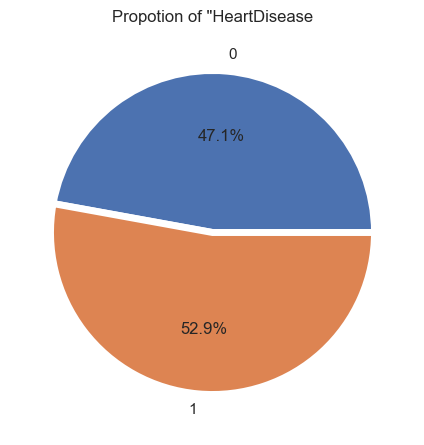

In [7]:
x = df['HD'].value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=['0', '1'], autopct = '%1.1f%%', wedgeprops = {'linewidth': 5})
plt.title('Propotion of "HeartDisease')
plt.style.use(['fivethirtyeight'])
plt.show()

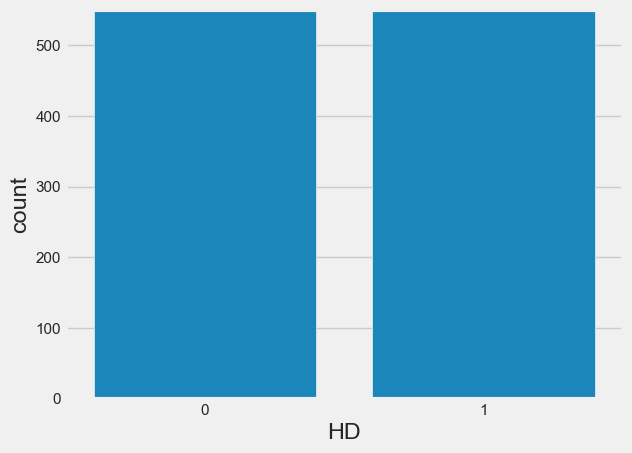

In [8]:
ax = sns.countplot(data = df, x = 'HD')

ax.bar_label(ax.containers[0])
ax.set_ylim(0, 550)

plt.show()

The data looks well-balanced.

<br>

## Numerical features

In [9]:
dtype = pd.DataFrame(df_info.summary().loc['types'] == 'numeric')
num_cols = dtype[dtype['types'] == True].index.to_list()
num_cols

['AG', 'CP', 'RBP', 'CL', 'REC', 'MHR', 'OP', 'STS']

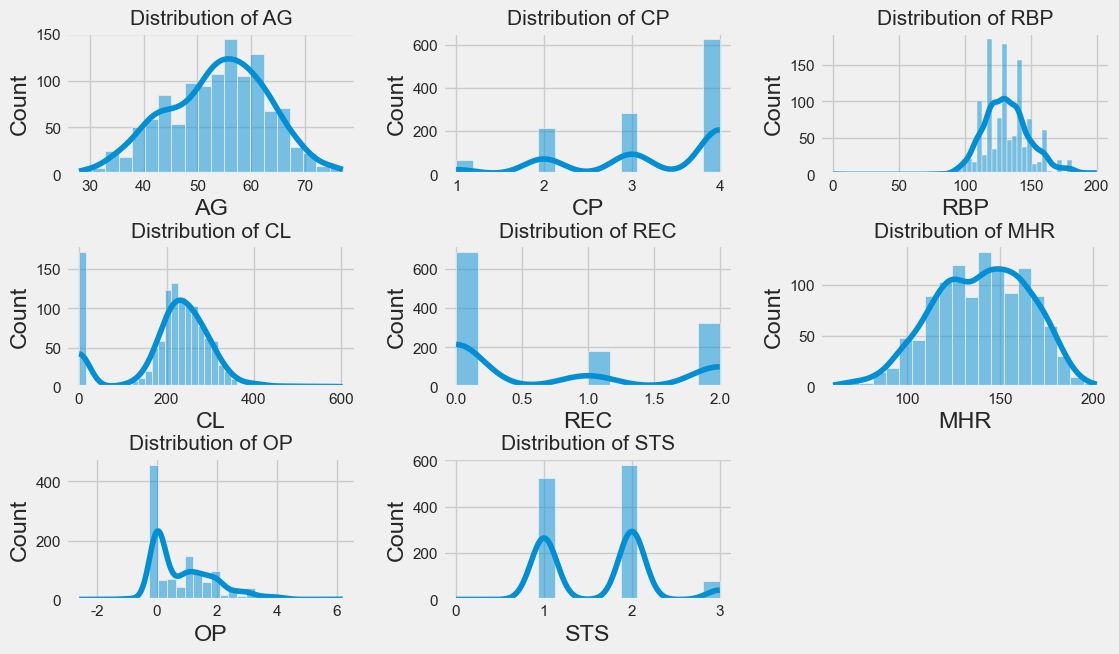

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (12, 7))
axes = axes.flatten()

for col, ax in zip(num_cols, axes):
    ax = sns.histplot(data = df, x = col, ax = ax, kde = True)
    ax.set_title(f"Distribution of {col}", fontsize=15)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
axes[-1].axis('off')
plt.show()

## Categorical Features

In [11]:
cat_cols = list(set(df.columns) - set(num_cols))
cat_cols.remove('HD')

cat_cols

['FBS', 'GD', 'EA']

In [12]:
df.columns

Index(['AG', 'GD', 'CP', 'RBP', 'CL', 'FBS', 'REC', 'MHR', 'EA', 'OP', 'STS',
       'HD'],
      dtype='object')

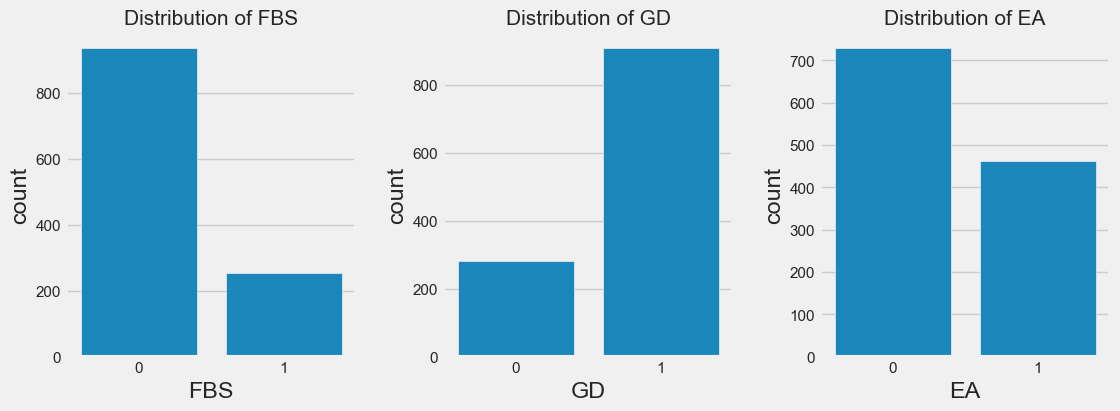

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (12, 4))
axes = axes.flatten()

for col, ax in zip(cat_cols, axes):
    ax = sns.countplot(data = df, x = col, ax = ax)
    ax.set_title(f"Distribution of {col}", fontsize=15)
    plt.subplots_adjust(hspace=0.5, wspace=0.3)
    
plt.show()

<Axes: >

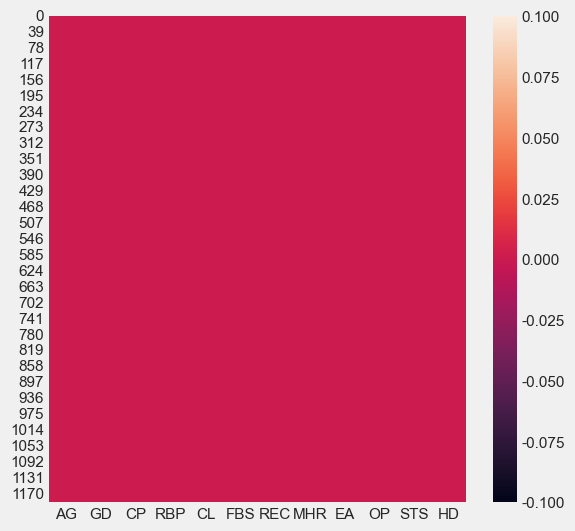

In [14]:
plt.figure(figsize=(6,6))
sns.heatmap(df.isnull())

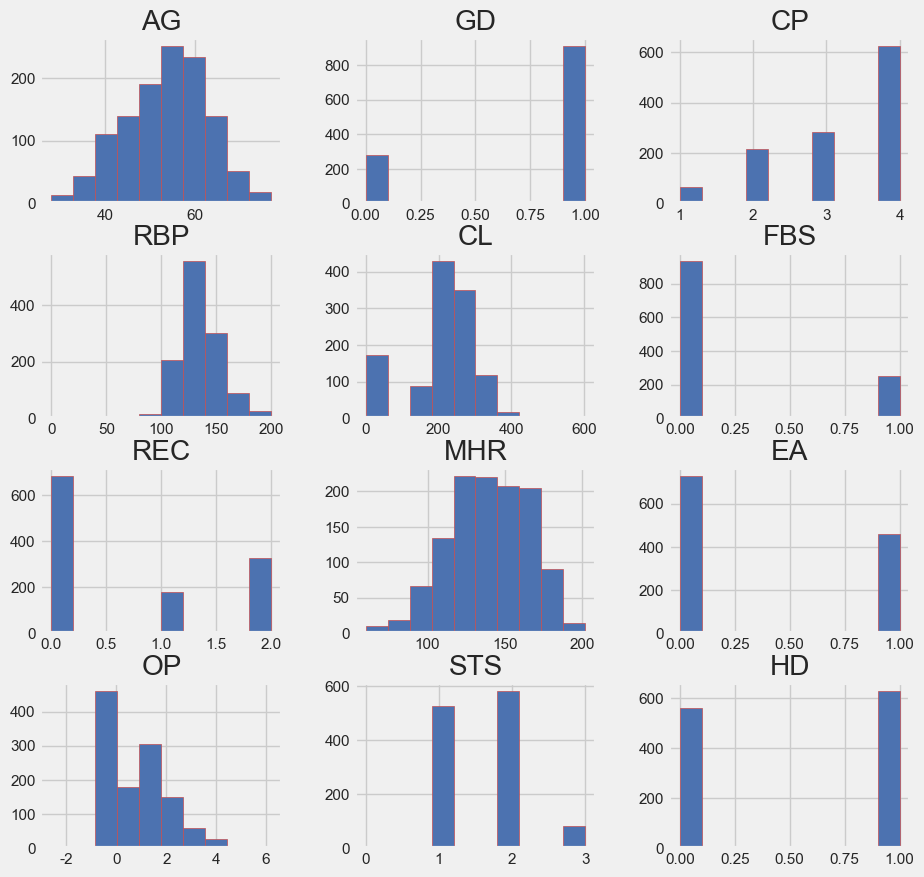

In [15]:
#histogram
df.hist(color='b',bins=10,ec='r',figsize=(10,10))
plt.show()

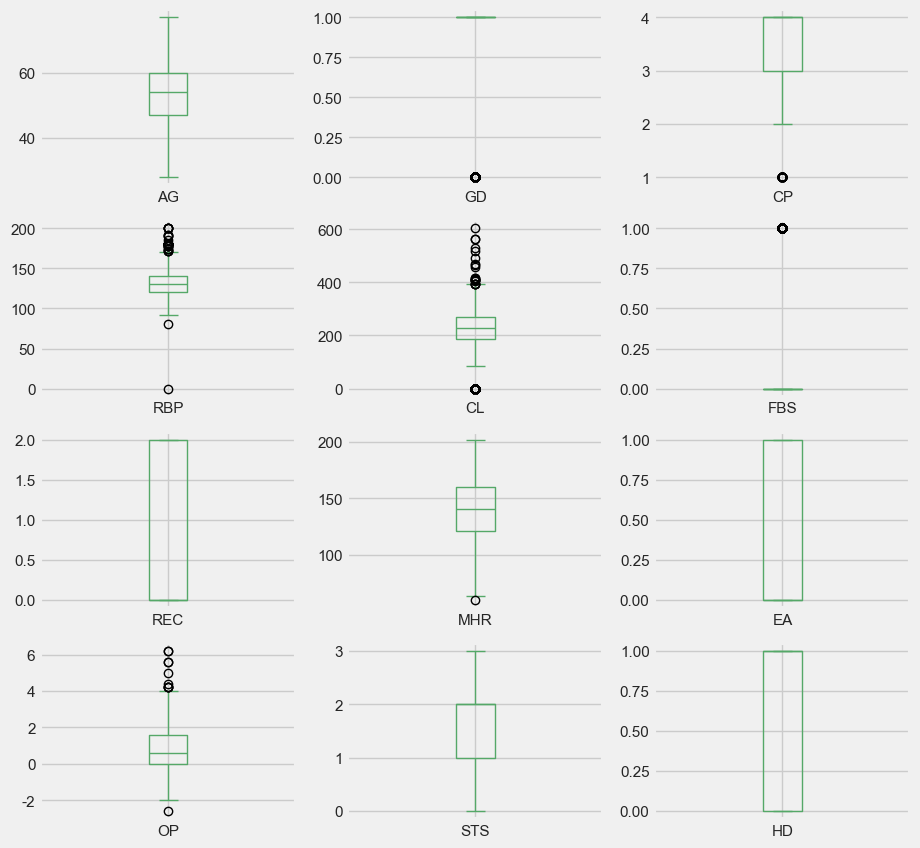

In [16]:
df.plot(color = 'g', kind='box', figsize=(10, 10), subplots=True, layout=(4,3))
plt.show()

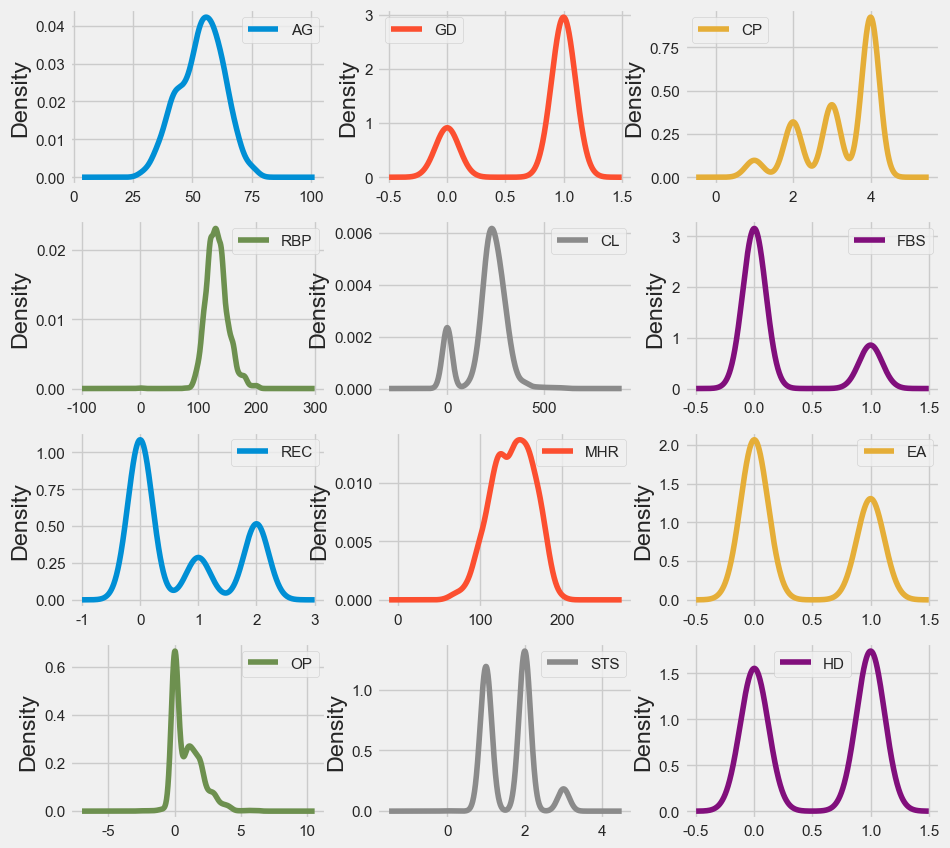

In [17]:
#Boxplot of each column
df.plot( kind='density', figsize=(10,10), subplots=True, layout=(4,3),sharex=False)
plt.show()

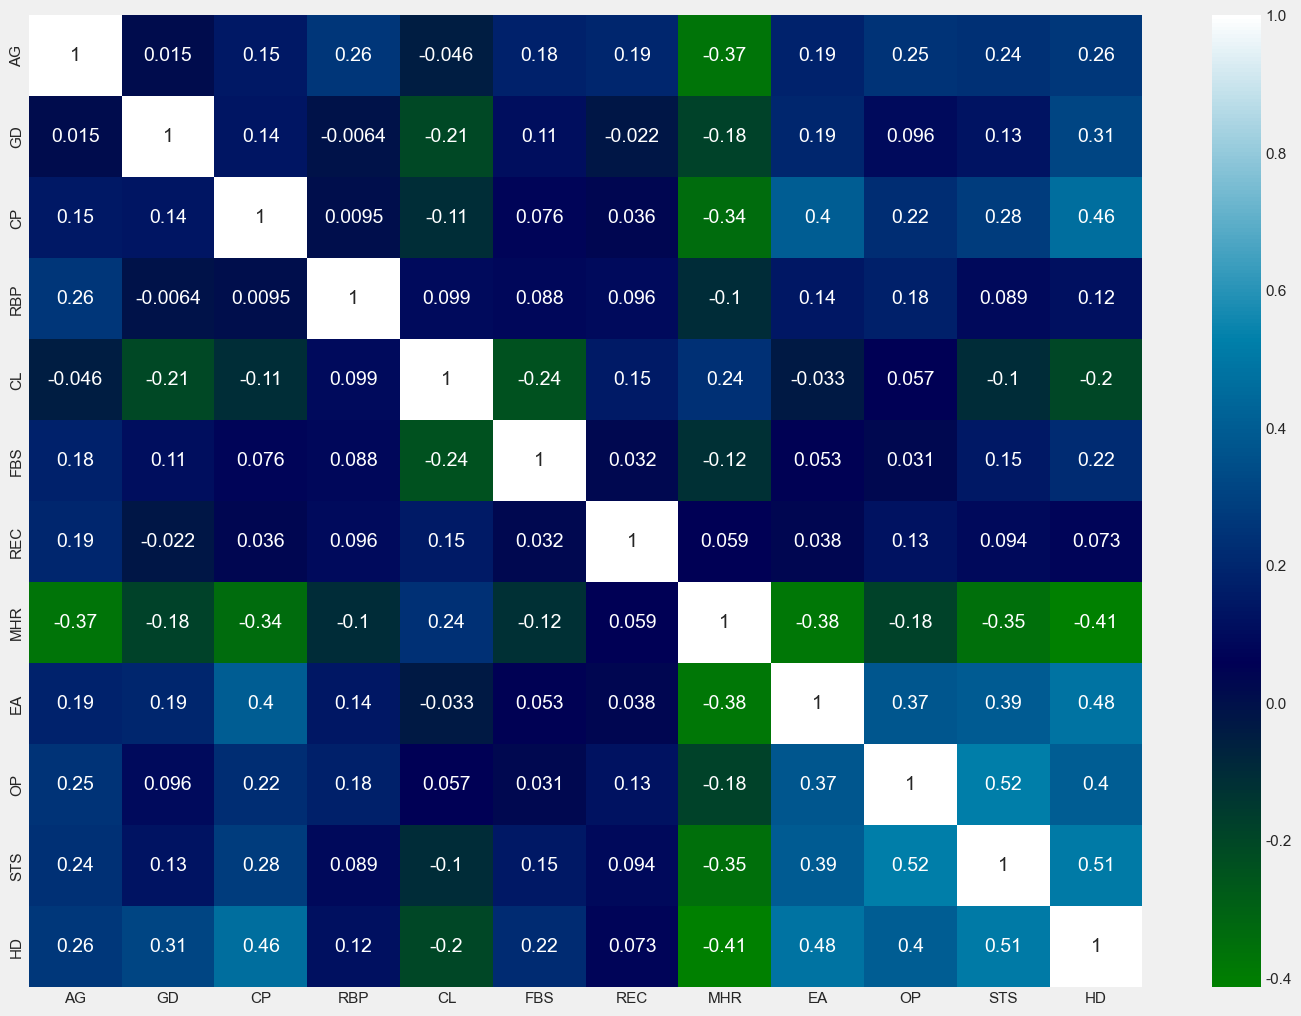

In [18]:
#get correlations of each features in dataset
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(16,12))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="ocean")

# Preprocessing

In [19]:
#df['FastingBS'] = df['FastingBS'].astype('O')

In [20]:
ss = StandardScaler()

df[num_cols] = ss.fit_transform(df[num_cols])

In [21]:
df = pd.get_dummies(df, drop_first = True)  # drop_first option

display(df.shape, df.head(10))

(1190, 12)

,AG,GD,CP,RBP,CL,FBS,REC,MHR,EA,OP,STS,HD
0,-1.466728,1,-1.318351,0.427328,0.775674,0,-0.802672,1.265039,0,-0.849792,-1.023217,0
1,-0.504600,0,-0.248932,1.516587,-0.299512,0,-0.802672,0.637758,0,0.071119,0.615583,1
2,-1.787437,1,-1.318351,-0.117301,0.716489,0,0.346762,-1.636136,0,-0.849792,-1.023217,0
3,-0.611503,0,0.820487,0.318402,0.035867,0,-0.802672,-1.244085,1,0.531575,0.615583,1
4,0.029915,1,-0.248932,0.971958,-0.151550,0,-0.802672,-0.695214,0,-0.849792,-1.023217,0
5,-1.573631,1,-0.248932,-0.661931,1.268878,0,-0.802672,1.186628,0,-0.849792,-1.023217,0
6,-0.932213,0,-1.318351,-0.117301,0.262741,0,-0.802672,1.186628,0,-0.849792,-1.023217,0
7,0.029915,1,-1.318351,-1.206560,-0.023317,0,-0.802672,0.088887,0,-0.849792,-1.023217,0
8,-1.787437,1,0.820487,0.427328,-0.033181,0,-0.802672,-0.381574,1,0.531575,0.615583,1
9,-0.611503,0,-1.318351,-0.661931,0.726353,0,-0.802672,-0.773625,0,-0.849792,-1.023217,0


Numeric features are scaled and others are successfully encoded by one-hot encoding.

## Correlation analysis

In [22]:
corr = df.corr().round(2)

In [23]:
# plt.figure(figsize = (13, 13))

# mask = np.zeros_like(corr, dtype = any)
# mask[np.triu_indices_from(mask)] = True

# heat_map = sns.heatmap(corr,
#                        annot = True,
#                        cmap = 'RdYlGn',
#                        mask = mask,
#                        linewidths = 0.01,
#                        cbar_kws = {'shrink' : .5})

* Strong correlation: ST, ExerciseAngina, ChestPainType, Oldpeak, MaxHR

# Module 3 

# Model ensembles

There are 3 kinds of ensembles generally used.

<br>


### 1. K-Fold Cross Validation

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample.

The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation. When a specific value for k is chosen, it may be used in place of k in the reference to the model, such as k=10 becoming 10-fold cross-validation.

Cross-validation is primarily used in applied machine learning to estimate the skill of a machine learning model on unseen data. That is, to use a limited sample in order to estimate how the model is expected to perform in general when used to make predictions on data not used during the training of the model.

It is a popular method because it is simple to understand and because it generally results in a less biased or less optimistic estimate of the model skill than other methods, such as a simple train/test split.

The general procedure is as follows:

1. Shuffle the dataset randomly.
2. Split the dataset into k groups
3. For each unique group:
    * Take the group as a hold out or test data set
    * Take the remaining groups as a training data set
    * Fit a model on the training set and evaluate it on the test set
    * Retain the evaluation score and discard the model
4. Summarize the skill of the model using the sample of model evaluation scores

**[Tip]** It is better to use `StratifiedKFold` when K-fold CV because it controls the percentage of each class of the target variable.  

<br>

<img 
     src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FluuGW%2FbtrgjGrj9g6%2FNOsrBEQIr2uTRynM2PZ3h1%2Fimg.png">
     
<br>


Source: https://scikit-learn.org/stable/modules/cross_validation.html, https://machinelearningmastery.com/k-fold-cross-validation/


<br><br>

### 2. Voting

Voting is an ensemble method that combines the performances of multiple models to make predictions.

Since voting relies on the performance of many models, they will not be hindered by large errors or misclassifications from one model. A poor performance from one model can be offset by a strong performance from other models.


* **Hard Voting vs. Soft Voting**

There are two ways in voting procedure. Classification by hard-voting is like Winner Take All system. Out of multiple outputs produced by the classifiers, the majority output is chosen to be the final result of the model.

In contrast, soft-voting is a voting process which every classifiers' outputs are taken into account. Soft-voting sums the predicted probabilities for class lables and returns the final classification with the largest sum probability.

<br>

<img 
     src="https://media.vlpt.us/images/jiselectric/post/d3eabe8e-b223-4e6d-8a9f-3442f8767d9b/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-01-24%2017.42.36.png">
     
<br>

source: https://towardsdatascience.com/combine-your-machine-learning-models-with-voting-fa1b42790d84, https://velog.io/@jiselectric/Ensemble-Learning-Voting-and-Bagging-at6219ae

<br><br>

### 3. Stacking

While bagging and boosting used homogenous weak learners for ensemble, Stacking often considers heterogeneous weak learners, learns them in parallel, and combines them by training a meta-learner to output a prediction based on the different weak learner’s predictions. A meta learner inputs the predictions as the features and the target being the ground truth values in data D(Fig 2.), it attempts to learn how to best combine the input predictions to make a better output prediction. 

A general approach for stacking is using meta model as Linear Regression (regression problem) or Logistic Regression (classification problem) to combine the predictions of the sub-models with any learning algorithm.

<br>

<img 
     src="https://editor.analyticsvidhya.com/uploads/39725Stacking.png">
     
<br>


source: https://www.analyticsvidhya.com/blog/2021/08/ensemble-stacking-for-machine-learning-and-deep-learning/

<br><br>

In [25]:
# First of all, we need to split the data as train and test dataset.
# We will use train dataset for training and validation.

X = df.drop(['HD'], axis=1)
y = df['HD']

X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size = 0.20, stratify = y, random_state=42)

display(X_trn.shape, y_trn.shape, X_tst.shape, y_tst.shape)

(952, 11)

(952,)

(238, 11)

(238,)

In [26]:
X_trn.reset_index(drop=True, inplace=True)
y_trn.reset_index(drop=True, inplace=True)
X_tst.reset_index(drop=True, inplace=True)
y_tst.reset_index(drop=True, inplace=True)

# Hyper Parameter Optimization


Just for my reference about main hyper parameters of LGBM and XGBoost.

## LGBM

* First of all, we should notice that it is different from other tree models like XGBoost in terms of the way for the growth of tree. LGBM grows the tree based on a leaf-wise.

* You can check out the detailed explanation from the official documentation **[here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)**

* I learnt a lot about the LGBM HPO using OPTUNA from **[this great work](https://www.kaggle.com/bextuychiev/lgbm-optuna-hyperparameter-tuning-w-understanding)**.

* There are largely 3 kinds of hyperparameters we could get benefits from HPO in case of most tree-based model. But usually these have a lot of overlap, and trade-offs(increasing in one may risk a decrease in another.

<br><br>

**1. Hyperparameters that control the tree structure**
    
* **`num_leaves`** : controls the number of decision leaves in a single tree. Theoretically we can set `num_leaves = 2^(max_depth)` to obtain the same number of leaves as depth-wise tree. But with the reason that a leaf-wise tree is typically much deeper than a depth tree for a same `num_leaves`. Therefore you should let it be smaller than `2^(max_depth)` when tuning `num_leaves`. The official documentation recommends that it would be better to set it to be ranged on approx. 60% of the value of `2^(max_depth)`       
        
* **`max_depth`** : The higher `max_depth`, the deeper levels the tree has, which makes it more complex and prone to overfit. The empirical recommendation for `max_depth` is a value between 3 and 12.
        
* **`min_data_in_leaf`** : Another important parameter to prevent overfitting in a leaf-wise tree. Its optimal value depends on the number of training samples and `num_leaves`. In practice, setting it to hundreds or thousands is enough for a large dataset.

<br>

**2. Hyperparameters for better accuracy**

For the better accuracy, there are 2 main hyperparameters, `n_estimators` and `learning_rate`. `n_estimators` controls the number of decision trees while `learning_rate` is the step size parameter of the gradient descent to find the global minimum. In other words, we need to find the best combination of `n_estimators` and `learning_rate` in LGBM.

* **`n_estimators`** : use large number with `early_stopping` option.

* **`learning_rate`** : It controls the learning speed. the smaller `learning_rate`, the longer the time for learning. Typically the values lie within 0.01 and 0.1.

<br>

**3. Hyperparameters that control the overfitting**

* **`lambda_l1`, `lambda_l2`** : specify L1 and L2 regularization, respectively. A good search range is (0.0, 1.0) for both. They correspond to `reg_lambda`, `reg_alpha` in XGBoost.

* **`min_gain_to_split`** : This value is the minimal gain to perform split. A conservative search range is (0, 15). It can be used as extra regularization in large parameter grids. It corresponds to `gamma` in XGBoost.

* **`bagging_fraction`(must used with `bagging_freq`)** : It lie within 0.0 and 1.0 as a percentage of training samples to be used to train each tree. you should understand how `bagging_freq` works with bagging fraction when using `bagging_fraction`. 0 means disable bagging `k` means perform bagging at every `k` iteration. Every `k`-th iteration, LightGBM will randomly select `bagging_fraction * 100 %` of the data to use for the next `k` iterations

* **`feature_fraction`** : specifies the percentage of features to sample when training each tree. So, it also takes a value between (0, 1). It corresponds to `colsample_bytree` in XGBoost.

<br><br>
    

## XGBoost

* First of all, we should notice that it is different from other tree models like XGBoost in terms of the way for the growth of tree. LGBM grows the tree based on a leaf-wise.

* You can check out the detailed explanation from the official documentation **[here](https://xgboost.readthedocs.io/en/stable/)**

* There are largely 3 kinds of hyperparameters we could get benefits from HPO in case of most tree-based model. But usually these have a lot of overlap, and trade-offs(increasing in one may risk a decrease in another.

<br><br>

**1. Hyperparameters that control the tree structure**
    
<!-- * **`num_leaves`** : controls the number of decision leaves in a single tree. Theoretically we can set `num_leaves = 2^(max_depth)` to obtain the same number of leaves as depth-wise tree. But with the reason that a leaf-wise tree is typically much deeper than a depth tree for a same `num_leaves`. Therefore you should let it be smaller than `2^(max_depth)` when tuning `num_leaves`. The official documentation recommends that it would be better to set it to be ranged on approx. 60% of the value of `2^(max_depth)`        -->
        
* **`max_depth`** : The higher `max_depth`, the deeper levels the tree has, which makes it more complex and prone to overfit. The empirical recommendation for `max_depth` is a value between 3 and 12.
        
<!-- * **`min_data_in_leaf`** : Another important parameter to prevent overfitting in a leaf-wise tree. Its optimal value depends on the number of training samples and `num_leaves`. In practice, setting it to hundreds or thousands is enough for a large dataset. -->

<br>

**2. Hyperparameters for better accuracy**

For the better accuracy, there are 2 main hyperparameters, `n_estimators` and `learning_rate`. `n_estimators` controls the number of decision trees while `learning_rate` is the step size parameter of the gradient descent to find the global minimum. In other words, we need to find the best combination of `n_estimators` and `learning_rate` in LGBM.

* **`n_estimators`** : use large number with `early_stopping` option.

* **`learning_rate`** : It controls the learning speed. the smaller `eta`, the longer the time for learning. Typically the values lie within 0.01 and 0.1. Alias is `eta`

<br>

**3. Hyperparameters that control the overfitting**

* **`reg_lambda`, `reg_alpha`** : specify L1 and L2 regularization, respectively. A good search range is (0.0, 1.0) for both. They correspond to `lambda_l1`, `lambda_l2` in XGBoost.

* **`gamma`** : This value is the minimal gain to perform split. In other words, it is the minimum loss reduction required to make a further partition on a leaf node of the tree.  I will use the same conservative search range (0, 15) as explained in LGBM part above. The larger gamma is, the more conservative the algorithm will be. It corresponds to `min_gain_to_split` in LGBM.

<!-- * **`bagging_fraction`(must used with `bagging_freq`)** : It lie within 0.0 and 1.0 as a percentage of training samples to be used to train each tree. you should understand how `bagging_freq` works with bagging fraction when using `bagging_fraction`. 0 means disable bagging `k` means perform bagging at every `k` iteration. Every `k`-th iteration, LightGBM will randomly select `bagging_fraction * 100 %` of the data to use for the next `k` iterations -->

* **`sub_sample`** : Setting it to 0.5 means that XGBoost would randomly sample half of the training data prior to growing trees. and this will prevent overfitting. It takes a value between (0.0, 1.0).

* **`colsample_bytree`** : specifies the percentage of features to sample when training each tree. It takes a value between (0.0, 1.0). It corresponds to `feature_fraction` in LGBM.

<br><br>

# Module 4

# Using PyCaret

In [48]:
#!pip install pycaret
#!pip install pycaret --user

In [49]:
import pycaret
from pycaret.classification import *

In [50]:
cat_cols = list(set(df.columns) - set(num_cols))
cat_cols.remove('HD')

cat_cols

['FBS', 'GD', 'EA']

## Set up

## Creating Models

In [51]:
setup(data = df, 
      target = 'HD',
      session_id = 42,
      preprocess = False,
      numeric_features = cat_cols
     )
#       silent = True

,Description,Value
0,Session id,42
1,Target,HD
2,Target type,Binary
3,Original data shape,"(1190, 12)"
4,Transformed data shape,"(1190, 12)"
5,Transformed train set shape,"(833, 12)"
6,Transformed test set shape,"(357, 12)"
7,Numeric features,3


In [52]:
top5 = compare_models(sort='Recall',n_select = 5,exclude=['ridge','svm','dummy','knn','dt','qda','ada', 'nb', 'lda', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9112,0.9535,0.9364,0.9006,0.9176,0.8215,0.8233,0.0940
lightgbm,Light Gradient Boosting Machine,0.9076,0.9525,0.9364,0.8948,0.9147,0.8141,0.8160,0.0850
xgboost,Extreme Gradient Boosting,0.9016,0.9497,0.9318,0.8889,0.9093,0.8019,0.8041,0.0790
et,Extra Trees Classifier,0.9029,0.9642,0.9250,0.8961,0.9098,0.8046,0.8063,0.0530
catboost,CatBoost Classifier,0.8920,0.9531,0.9068,0.8925,0.8988,0.7830,0.7847,0.7480
lr,Logistic Regression,0.8259,0.8940,0.8364,0.8403,0.8359,0.6505,0.6548,0.7610


### Creating Meta Learners for Stacking

In [55]:
meta_learner1 = stack_models(estimator_list = [et, rf, catboost, xgboost, lightgbm], meta_model = KNeighborsClassifier())# Define meta learner

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8214,0.8835,0.8636,0.8085,0.8352,0.6408,0.6425
1,0.9048,0.9591,0.8636,0.9500,0.9048,0.8100,0.8136
2,0.9167,0.9534,0.9091,0.9302,0.9195,0.8331,0.8334
3,0.8554,0.9534,0.9091,0.8333,0.8696,0.7081,0.7115
4,0.8675,0.9458,0.8864,0.8667,0.8764,0.7336,0.7338
5,0.9277,0.9726,0.9318,0.9318,0.9318,0.8549,0.8549
6,0.9398,0.9755,0.9318,0.9535,0.9425,0.8793,0.8795
7,0.9398,0.9726,1.0000,0.8980,0.9462,0.8782,0.8848
8,0.8675,0.9458,0.8636,0.8837,0.8736,0.7344,0.7346


In [56]:
evaluate_model(meta_learner1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [57]:
meta_learner2 = stack_models(estimator_list = [et, rf, catboost, xgboost, lightgbm], meta_model = LinearDiscriminantAnalysis())# Define meta learner

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8452,0.8580,0.9091,0.8163,0.8602,0.6880,0.6930
1,0.9167,0.9540,0.9091,0.9302,0.9195,0.8331,0.8334
2,0.9048,0.9568,0.9318,0.8913,0.9111,0.8087,0.8096
3,0.8675,0.9481,0.8864,0.8667,0.8764,0.7336,0.7338
4,0.9277,0.9534,0.9773,0.8958,0.9348,0.8540,0.8581
5,0.9157,0.9738,0.9545,0.8936,0.9231,0.8300,0.8322
6,0.9277,0.9732,0.9545,0.9130,0.9333,0.8545,0.8555
7,0.9036,0.9551,0.9545,0.8750,0.9130,0.8054,0.8092
8,0.9277,0.9575,0.9091,0.9524,0.9302,0.8553,0.8563


In [58]:
evaluate_model(meta_learner2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Proposed Stacking Model

In [86]:
meta_learner3 = stack_models(estimator_list = [et, rf, catboost, xgboost, lightgbm], meta_model = LogisticRegression())

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8690,0.8943,0.9545,0.8235,0.8842,0.7354,0.7460
1,0.9167,0.9477,0.9318,0.9111,0.9213,0.8328,0.8330
2,0.8929,0.9591,0.9091,0.8889,0.8989,0.7850,0.7852
3,0.8916,0.9551,0.9091,0.8889,0.8989,0.7820,0.7823
4,0.9157,0.9446,0.9545,0.8936,0.9231,0.8300,0.8322
5,0.9518,0.9808,0.9773,0.9348,0.9556,0.9030,0.9040
6,0.9398,0.9714,0.9545,0.9333,0.9438,0.8789,0.8792
7,0.9398,0.9755,0.9773,0.9149,0.9451,0.8785,0.8809
8,0.8916,0.9604,0.9091,0.8889,0.8989,0.7820,0.7823


In [54]:
evaluate_model(meta_learner3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

## Proposed Voting Model

In [78]:
Voting = blend_models(estimator_list =[et, rf, catboost, xgboost, lightgbm], method = 'hard')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8690,0.0000,0.9545,0.8235,0.8842,0.7354,0.7460
1,0.8929,0.0000,0.9091,0.8889,0.8989,0.7850,0.7852
2,0.9405,0.0000,0.9545,0.9333,0.9438,0.8805,0.8808
3,0.8554,0.0000,0.9318,0.8200,0.8723,0.7072,0.7149
4,0.8916,0.0000,0.9318,0.8723,0.9011,0.7814,0.7835
5,0.9518,0.0000,0.9773,0.9348,0.9556,0.9030,0.9040
6,0.9398,0.0000,0.9545,0.9333,0.9438,0.8789,0.8792
7,0.9398,0.0000,1.0000,0.8980,0.9462,0.8782,0.8848
8,0.8916,0.0000,0.9091,0.8889,0.8989,0.7820,0.7823


In [79]:
evaluate_model(Voting)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Module 5

### Shap Analysis

In [97]:
import shap
shap.initjs()

In [98]:
# Defining the Dependedent and the Independent Variable
X = df.drop('HD', axis=1)
y = df['HD']

In [100]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Proposed Voting SHAP Analysis

In [101]:
explainer=shap.Explainer(meta_learner3)
shap_values=explainer(X_test)

In [102]:
np.shape(shap_values.values)

(357, 11)

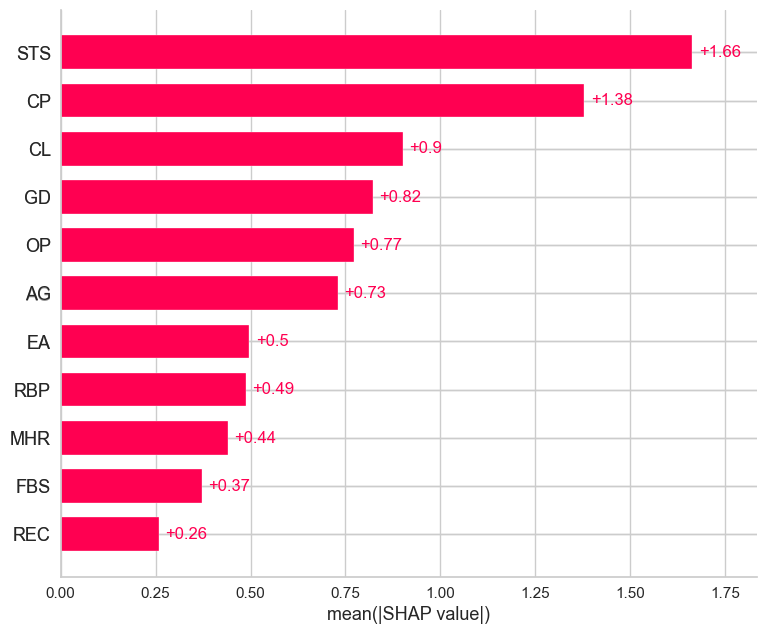

In [103]:
shap.plots.bar(shap_values, max_display=len(shap_values.feature_names))

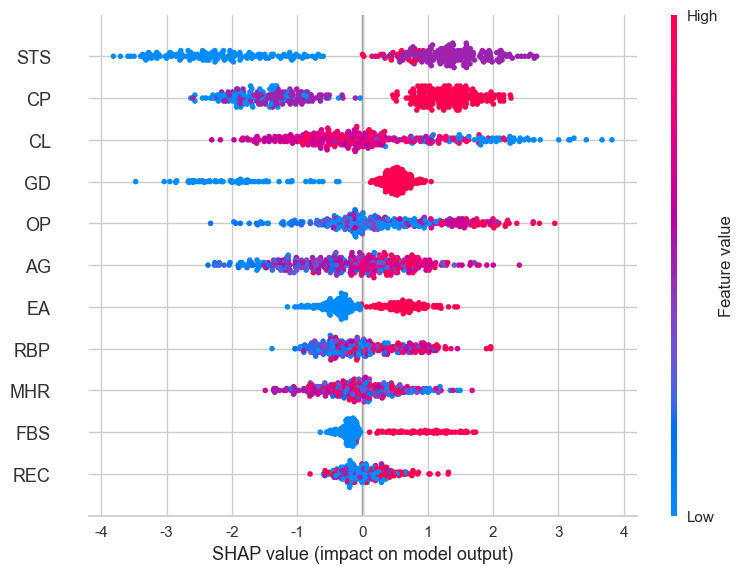

In [104]:
shap.summary_plot(shap_values, X_test)

In [105]:
shap.plots.force(shap_values[5])

In [106]:
shap.plots.force(shap_values[0:100])

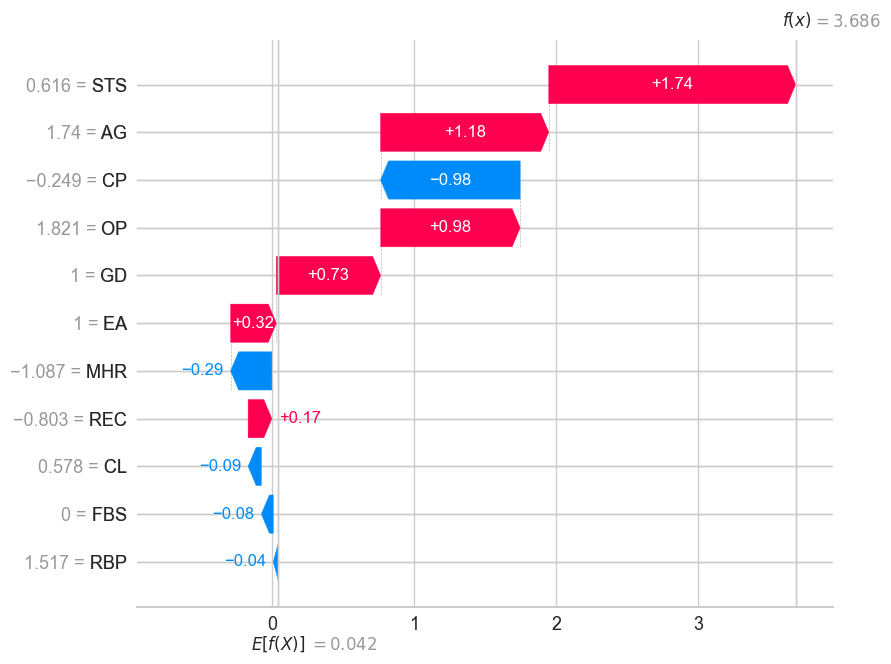

In [119]:
shap.plots.waterfall(shap_values[20], max_display=len(shap_values.feature_names))

### Proposed Stacking SHAP Analysis

In [107]:
explainer=shap.Explainer(Voting)
shap_values=explainer(X_test)

In [108]:
np.shape(shap_values.values)

(357, 11)

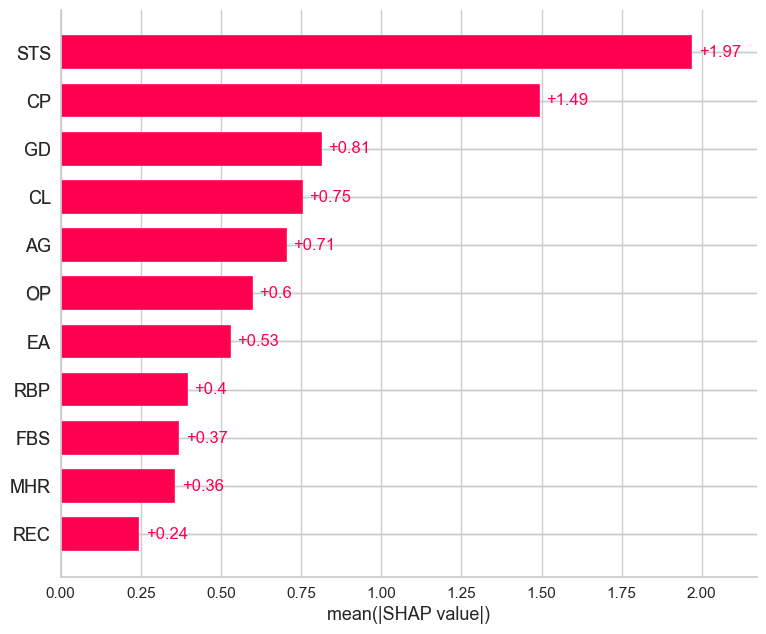

In [109]:
shap.plots.bar(shap_values, max_display=len(shap_values.feature_names))

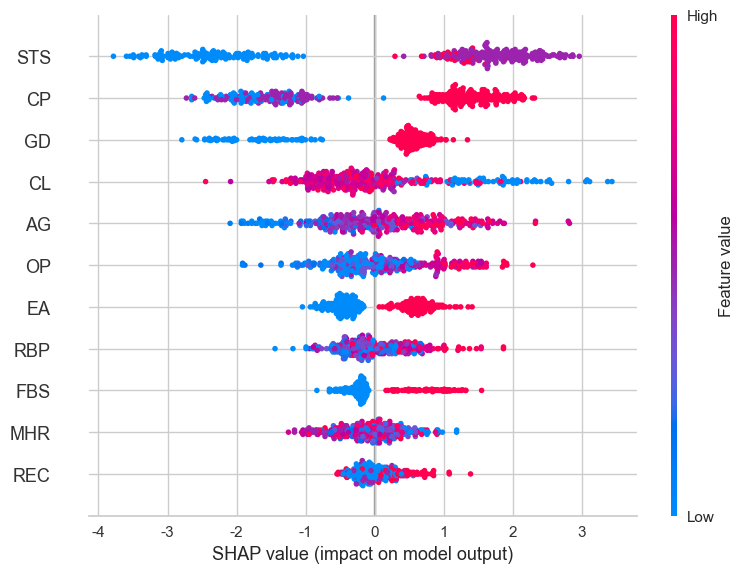

In [110]:
shap.summary_plot(shap_values, X_test)

In [111]:
shap.plots.force(shap_values[10])

In [113]:
shap.plots.force(shap_values[0:100])

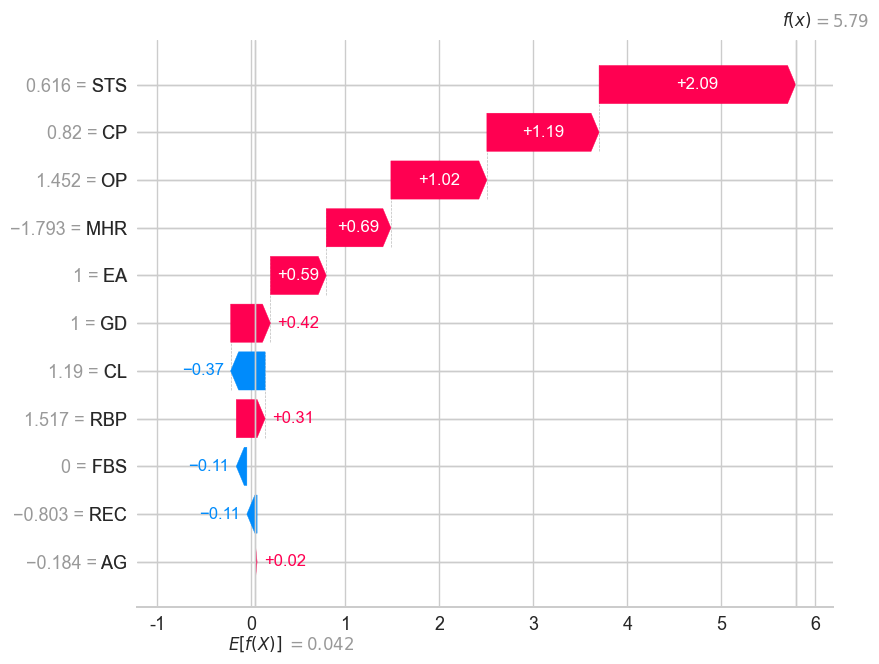

In [122]:
shap.plots.waterfall(shap_values[25], max_display=len(shap_values.feature_names))

### End of Experiment